# **SONG RECOMMENDER**

### MARIA KOILALOU - JUSTINE LE BOURGE 

**GROUP 11**

Project for Artificial Intelligence [EARIN] Summer 2023

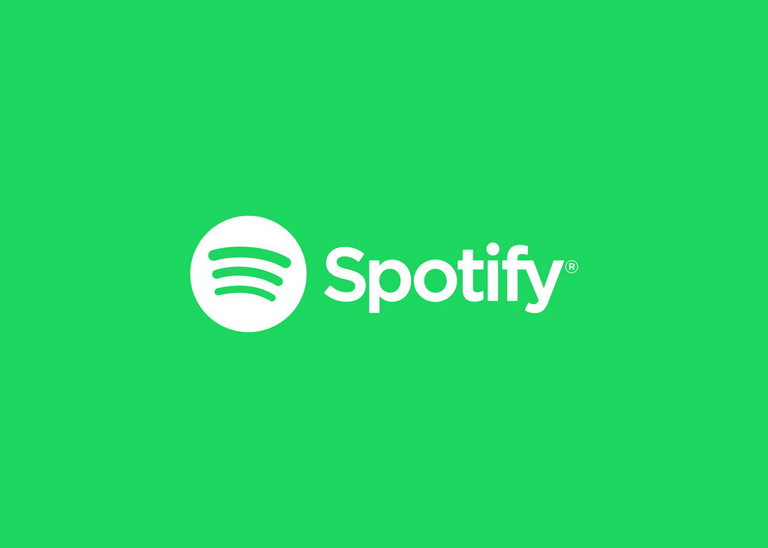

## Table of Contents

* 1. [Problem Definition](#section-one)
* 2. [Dataset](#section-two)
    - 2.1. [Overview](#subsection2-one)
    - 2.2. [Pre-Processing](#subsection2-two)
    - 2.3. [PCA](#subsection2-three)
* 3. [Technical Approach](#section-three)
    - 3.1 [Architecture](#subsection3-one)
    - 3.2 [Training Details](#subsection3-two)
        - [K-means Clustering](#subsection3two-one)
            - [Testing of different parameters](#subsection3two1-one)
            - [K-Means Evaluation](#subsection3two1-two)
        - [DBSCAN Clustering](#subsection3two-two)
            - [Testing of different parameters](#subsection3two2-one)
            - [DBSCAN Evaluation](#subsection3two2-two)
* 4. [Evaluation](#section-four)
    - 4.1. [Similarity Metrics](#subsection4-one)
    - 4.2. [Evaluation Metrics](#subsection4-two)
    - 4.3. [Subjective Prespective](#subsection4-three)
* 5. [Conclusion](#section-five)

<a id="section-one"></a>
# 1 **PROBLEM DEFINITION**


Our project aims to develop a sophisticated Song Recommender System using a Spotify dataset. The goal is to create a model that can provide song recommendations to users, based on the song's characteristics. By analyzing the informations provided by the dataset, we will identify the key attributes that determine whether a user will like a song or not.

In this project we are going to develop a program that uses a Spotify dataset. Spotify is a song streaming app and platform that most people use and almost every artist uploads their songs there. We will start by exploring the Spotify dataset, which contain extensive information on songs, artists, and song characteristics. These datasets will serve as a valuable resource for training our models.

First in our project we are going to examine the datasets. The songs, the artists and the characteristics of the songs and the relationship between them.
Based on the user's input we are going to search for similar song's that he might enjoy.

In our project we are going to use Python Notebooks for a quicker way to examine data.

We import the necessary libraries to start our analysis:

In [ ]:
# General libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import altair as alt
import random

# Metrics libraries
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors

# Clustering libraries
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Data procressing libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split

alt.renderers.enable('kaggle')
warnings.simplefilter("ignore")

<a id="section-two"></a>
# 2 **DATASET**
<a id="subsection2-one"></a>
## 2.1. *Overview*

First we are going to examine the whole dataset and create some graphs and tables with helpful information about the data that we are going to use later.

In [ ]:
# Read Dataset
data = pd.read_csv("/kaggle/input/spotifyclassification/data.csv")

In [ ]:
# Print the Start of the Dataset to examine the datas
data.head()

We notice that the first column of the Dataset is empty so we fix it not to be unnamed. We also erase `target` value because we aren't going to use it for our analysis. The model is going to use unsupervised learning techniques so it won;t need a 'target' variable.

In [ ]:
# Fix Unnamed column's name
data = data.drop("Unnamed: 0", axis="columns")
# Drop unnecessary 'target' column
data.drop('target', axis=1, inplace=True)

In [ ]:
# Drop duplicate values
data = data.drop_duplicates()

In [ ]:
# Check for null values in the DataFrame
data.isnull().sum()

In [ ]:
# Print the type of every attribute of the Dataset
data.info()

We check some basic information about the attribute’s values such as total count, mean, minimum and maximum value:

In [ ]:
# Basic description of the dataset
data.describe()

In [ ]:
# Print the size of the Dataset 
data.shape

We start to examine the **artists** that are included in our dataset

In [ ]:
# Set the title and axis labels
values = data['artist'].value_counts().tolist()[:20]
names = list(dict(data['artist'].value_counts()).keys())[:20]

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 7))  # smaller figsize
ax.bar(names, values, color="#7CEA46")

# Set the title and axis labels
ax.set_title("Top Artists")
ax.set_xlabel("Artist")
ax.set_ylabel("Count")

# Display the plot
plt.xticks(rotation=90)
plt.show()


We can see that our dataset features multiple artists with `Drake` being the one with the most songs.


We split the data to `numeric` and `categorical` :

In [ ]:
# Categorical data
categorical_data = data.select_dtypes(include=['object'])
print("Categorical columns: ", categorical_data.columns.tolist())

# Numeric data
numeric_data = data.select_dtypes(include=['int64', 'float64'])
print("Numeric columns: ", numeric_data.columns.tolist())


We print the **Correlation Matrix** of the dataset to find the correlation between the attributes. The ones with the higher correlation are the ones that we need to check because they will probably be important for the analysis.

In [ ]:
# Plot linear correlation matrix
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(numeric_data.corr(), annot=True, fmt='.1g', cmap="Greens_r", cbar=False)
plt.title('Linear Correlation Matrix')
plt.show()

We notice that the correlation between energy-loudness is really high and between acousticness-loudness and acousticness-energy is really low.

In [ ]:
# Check absolute correlation
corr_df = numeric_data.corr('spearman').stack().reset_index(name='corr')
corr_df.loc[corr_df['corr'] == 1, 'corr'] = 0  # Remove diagonal
corr_df['abs'] = corr_df['corr'].abs()
alt.Chart(corr_df).mark_circle().encode(
    x='level_0',
    y='level_1',
    size='abs',
    color=alt.Color('corr', scale=alt.Scale(scheme='blueorange', domain=(-1, 1)))
).properties(
    title={'text': 'Absolute Correlation', 'fontSize': 15},
    width=300,  
    height=300  
)



Based on the `Absolute Correlation` we make find the pairs of attributes that are more correlated with each other.
We see that the most correlated attributes are:
* energy-loudness 
* acousticness-loudness 
* acousticness-energy 
* danceability - valence




We use **heatmap** to review the correlation more clearly. We notice that there are some pairs that have larger absolute correlation than most of the others such as : 
* *loudness* and *energy*, 
* *acousticness* and *energy*, 
* *valence* and *danceability*

In [ ]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Scatter chart for "loudness" and "energy"
sns.regplot(ax=axes[0], y='loudness', x='energy', data=data, color='blue')
axes[0].set_title('Loudness vs Energy')

# Scatter chart for "acousticness" and "energy"
sns.regplot(ax=axes[1], y='energy', x='acousticness', data=data, color='green')
axes[1].set_title('Energy vs Acousticness')

# Scatter chart for "valence" and "danceability"
sns.regplot(ax=axes[2], y='valence', x='danceability', data=data, color='red')
axes[2].set_title('Valence vs Danceability')

# Make the layout tight
plt.tight_layout()
plt.show()


For `loudness` and `energy` we see a tight correlation because most of the points are close to the line of correlation.

For `energy` and `acousticness` we don't see a good correlation because most of the points are close to zero.

For ` danceability` and `valence` we also don't notice a good correlation because points are not close to the correlation line.

So we create a new attribute about `loudness` and `energy` , maybe their ration value is going to play an important role in our analysis because of their strong correlation

In [ ]:
# Create new attributes
data['energy_loudness_ratio'] = data['energy'] / data['loudness']
# Append the new features to numeric_data
numeric_data = pd.concat([numeric_data, data[['energy_loudness_ratio']]], axis=1)

data.columns

We print **Histograms** for all the numeric columns to check the values of each attribute

In [ ]:
sns.set_palette("Greens_r")
num_cols = data.select_dtypes(include="number").columns
fig, axes = plt.subplots(5, 3, figsize=(10, 10))
axes = axes.flatten()
ax_no = 0
for col in num_cols:
    sns.histplot(data=data, x=col, bins=25, kde=True, ax=axes[ax_no])
    ax_no += 1
plt.tight_layout()  # Adjust the layout to prevent overlapping labels
plt.show()

<a id="subsection2-two"></a>
## 2.2. *Pre-Processing*

We clean the data so we feed only the important variables on the model

We notice that some attributes such as `mode`, `time_signature` don't have different values between the different songs on the dataset so they are not defined characteristics that we need for our analysis.

In [ ]:
data.drop('mode', axis=1, inplace=True)
data.drop('time_signature', axis=1, inplace=True)

We also split our numerical datas to `continuous` and `discrete` columns to continue with our analysis

In [ ]:
# Continuous Columns
continuous_cols = ['acousticness', 'danceability', 'duration_ms', 'energy',
                   'liveness', 'loudness', 'tempo', 'valence', 'speechiness', 'instrumentalness','energy_loudness_ratio']

# Discrete Columns
discrete_cols = ['key']

We **scale** the `continuous` data of the dataset :

In [ ]:
# Create a StandardScaler object
scaler = StandardScaler()
# Apply scaling to the numeric features
scaled_features = scaler.fit_transform(numeric_data[continuous_cols])

# Create a new DataFrame with the scaled numeric features
data[continuous_cols] = pd.DataFrame(scaled_features, columns=data[continuous_cols].columns)

We perform **One-Hot Encoding** for the `discrete` data in our dataset.

In [ ]:
# Perform one-hot encoding
one_hot_encoded_data = pd.get_dummies(data, columns=discrete_cols, drop_first=True)
data = pd.concat([data.drop(columns=discrete_cols), one_hot_encoded_data], axis=1)

# Check for duplicate columns
duplicate_columns = data.columns[data.columns.duplicated()]

# Drop duplicate columns
data = data.loc[:, ~data.columns.duplicated()]

data = data.dropna()

# Numeric Data
numeric_data = data.select_dtypes(include=[np.number])

numeric_data.columns

# Print the DataFrame after dropping duplicate columns
print(data.columns)

<a id="subsection2-three"></a>
## 2.3. *Principal Components Analysis (PCA)*

We performs **Principal Component Analysis (PCA)**, a dimensionality reduction technique, on a dataset containing numerical variables. It aims to identify the most influential features in the dataset that explain the most variance. 

We keep 15 components, then we fits the PCA model to the data, retrieves the explained variance for each component, and identifies the indices of the 15 components with the highest explained variance. 

Then we provide an overview of the most significant attributes in the dataset according to the PCA model.





In [ ]:
n_components = 15  # Number of components to keep

pca = PCA(n_components=n_components)
pca.fit(numeric_data)
explained_variance_ratio = pca.explained_variance_ratio_

# Get the indices of the components with the highest explained variance in descending order
top_components_indices = np.argsort(explained_variance_ratio)[::-1][:n_components]

# Get the corresponding column names
sorted_attributes_pca = [numeric_data.columns[i] for i in top_components_indices]

# Create a DataFrame with the sorted attributes from PCA
final_attributes_pca = pd.DataFrame({'Attributes': sorted_attributes_pca})

# Print the final DataFrame
print(final_attributes_pca)

We then proceed to keep the **10 most important** attributes of the dataset:

In [ ]:
# Get the top 10 attributes from PCA
pca_top_attributes = sorted_attributes_pca[:10]

# Get the 8 attributes with the highest importance based on their position in the combined list
final_attributes = pca_top_attributes[:10]

# Print the final attributes
for attribute in final_attributes:
    print(attribute)

We create the `new_data` frame with only the most important attributes:

In [ ]:
# Select the relevant columns from numeric_data
pca_data = numeric_data[final_attributes]

# Add the 'artist' and 'song_title' columns from the data DataFrame
pca_data.insert(0, 'song_title', data['song_title'])
pca_data.insert(1, 'artist', data['artist'])

new_data = pca_data.dropna()
new_data.head()

We also use **Principal Component Analysis (PCA)** for dimensionality reduction. 

In large datasets with many features , it's often helpful to reduce the number of dimensions to make data analysis or visualization more manageable and to help avoid the curse of dimensionality. 
PCA achieves this by transforming the original variables to a new set of variables, which are linear combinations of the original variables. 
These new variables, called principal components, are orthogonal (uncorrelated) and are ordered so that the first few retain most of the variation present in all of the original variables. 
The reduced-dimension data retains as much of the variance in the original data as possible. 
As a result, `PCA` allows us to analyze high-dimensional data in a lower-dimensional space, making it easier to identify patterns and trends, while also reducing computational complexity.


In [ ]:
# Perform PCA for dimensional reduction
n_components = 10  # Number of components to keep
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(new_data.iloc[:, 2:])  # Exclude 'song_title' and 'artist' columns

# Convert the reduced_data back to a DataFrame
reduced_data_pca = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(n_components)])
reduced_data_pca.insert(0, 'song_title', pca_data['song_title'])
reduced_data_pca.insert(1, 'artist', pca_data['artist'])
reduced_data_pca = reduced_data_pca.dropna()
reduced_data_pca.head()

As we can see the previous columns have been replaced with the columns that PCA generated.

<a id="section-three"></a>
# 3 **TECHNICAL APPROACH**
<a id="subsectionsection3-one"></a>
## 3.1. *Architecture*

We are going to use *Clustering Algorithms*.
This allows the recommendation system to suggest songs that are similar to the ones a user already likes. By creating these groups or "clusters" of similar songs, the system can offer more personalized and relevant recommendations.

For this we are going to implement **two** different algorithms. We are going to examine their results and evaluate their performance.

**K-means** is a clustering algorithm that aims to partition data points into a specified number of clusters (k) based on their similarity. It operates by iteratively assigning data points to the nearest centroid and updating the centroids based on the mean of the assigned points. This process continues until convergence is reached, resulting in k clusters with the centroids representing the cluster centers.

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** is another clustering algorithm that groups together data points based on their density. It defines clusters as areas of high-density separated by areas of low-density. DBSCAN requires two parameters: epsilon (eps), which specifies the radius of the neighborhood around a data point, and min_samples, which determines the minimum number of data points within the epsilon radius to form a dense region.

Both `K-means` and `DBSCAN` have their advantages and limitations. 
* **K-means** is a centroid-based algorithm that works well when the clusters have a spherical shape and are of similar size. It is sensitive to the initial placement of centroids and may converge to suboptimal solutions. 
* **DBSCAN**, on the other hand, is density-based and can discover clusters of arbitrary shapes. It is robust to noise and can handle clusters of different sizes. However, it requires tuning of parameters and may struggle with high-dimensional data.



<a id="subsection3-two"></a>
## 3.2. *Training details*

First we input a song title and search if the song exists in our dataset.
If there are multiple songs with this name we ask the user to input the artist's name.

In [ ]:
# Assume df is your DataFrame and 'song_title' and 'artist_name' are your columns
user_input = input("\n     Enter a song title:     \n").strip().lower()

# Convert the 'song_title' column to lower case
reduced_data_pca['song_title'] = reduced_data_pca['song_title'].str.lower()
reduced_data_pca['artist'] = reduced_data_pca['artist'].str.lower()

# Search in the lower case column
matched_songs = reduced_data_pca[reduced_data_pca['song_title'] == user_input]

if len(matched_songs) > 1:
    print("Multiple songs with that title found. Please specify the artist.")
    user_input_artist = input("Enter an artist name: ").strip().lower()
    
    # Create the 'artist_name_lower' column in the 'matched_songs' DataFrame
    matched_songs['artist'] = matched_songs['artist'].str.lower()
    
    matched_songs = matched_songs[matched_songs['artist'] == user_input_artist]
    matched_songs.drop(columns=['song_title', 'artist'], inplace=True)

elif len(matched_songs) == 1:
    print("Song found!")
    matched_songs.drop(columns=['song_title'], inplace=True)
    
else:
    print("Song not found.")


We use these functions to calculate the similarity between the song's of the same cluster.
We use `cosine_similarity` to calculate the percentage of the similarity between songs and we only keed the 10 most similar songs inside the song's cluster.

If inside the cluster there are more songs of this particular artist then even if there are not the most similar songs inside the cluster, they have a bigger chance to be appealing to the user.
So we change their similarity percentage to 100% to include them in our **most similar songs list**.

We use these functions to perform the `K-Means` and `DBSCAN` clustering.

For each algorithm we are going to perform **three test cases**, we are going to use **different parameters and metrics** are we are going to evaluate each case with **different evaluation methods**.


<a id="subsection3two-one"></a>
## **K-Means Clustering**

In the K-means algorithm, the number of clusters  is a critical parameter that directly influences the outcome of the clustering. 
So we are going to perform 3 different test cases with a different number od clusters for each one.

<a id="subsection3two1-one"></a>
###  Test Case One

For our first case we are going to use **5 clusters**

In [ ]:
# Perform clustering using KMeans algorithm
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(reduced_data_pca.iloc[:, 2:].values)

# Add the cluster labels as a new column in the reduced_data DataFrame
reduced_data_pca['cluster_label_kmeans'] = cluster_labels_kmeans

In [ ]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(reduced_data_pca.iloc[:, 2:-2])  # Exclude 'song_title', 'artist', 'cluster_label' columns

# Create a DataFrame for t-SNE visualization
tsne_df = pd.DataFrame(data={
    'X': transformed_data[:, 0],
    'Y': transformed_data[:, 1],
    'Cluster_Kmeans': reduced_data_pca['cluster_label_kmeans'],
})

# Visualize K-means clustering results
plt.figure(figsize=(7, 6))
plt.scatter(tsne_df['X'], tsne_df['Y'], c=tsne_df['Cluster_Kmeans'], cmap='viridis')
plt.title('t-SNE with K-means Clustering Labels 1')
plt.show()

In [ ]:
# Calculate Silhouette Coefficient kmeans
silhouette_score = metrics.silhouette_score(reduced_data_pca.iloc[:, 2:-2], reduced_data_pca['cluster_label_kmeans'])
print(f'Silhouette Coefficient: {silhouette_score}')

# Calculate Calinski-Harabasz Index
calinski_harabasz_score = metrics.calinski_harabasz_score(reduced_data_pca.iloc[:, 2:-2], reduced_data_pca['cluster_label_kmeans'])
print(f'Calinski-Harabasz Index: {calinski_harabasz_score}')

### Test Case Two

For our first case we are going to use **15 clusters**

In [ ]:
# Perform clustering using KMeans algorithm
n_clusters = 15  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(reduced_data_pca.iloc[:, 2:].values)

# Add the cluster labels as a new column in the reduced_data DataFrame
reduced_data_pca['cluster_label_kmeans'] = cluster_labels_kmeans


In [ ]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(reduced_data_pca.iloc[:, 2:-2])  # Exclude 'song_title', 'artist', 'cluster_label' columns

# Create a DataFrame for t-SNE visualization
tsne_df = pd.DataFrame(data={
    'X': transformed_data[:, 0],
    'Y': transformed_data[:, 1],
    'Cluster_Kmeans': reduced_data_pca['cluster_label_kmeans'],
})

# Visualize K-means clustering results
plt.figure(figsize=(7, 6))
plt.scatter(tsne_df['X'], tsne_df['Y'], c=tsne_df['Cluster_Kmeans'], cmap='viridis')
plt.title('t-SNE with K-means Clustering Labels 2')
plt.show()

In [ ]:
# Calculate Silhouette Coefficient kmeans
silhouette_score = metrics.silhouette_score(reduced_data_pca.iloc[:, 2:-2], reduced_data_pca['cluster_label_kmeans'])
print(f'Silhouette Coefficient: {silhouette_score}')

# Calculate Calinski-Harabasz Index
calinski_harabasz_score = metrics.calinski_harabasz_score(reduced_data_pca.iloc[:, 2:-2], reduced_data_pca['cluster_label_kmeans'])
print(f'Calinski-Harabasz Index: {calinski_harabasz_score}')

### Test Case Three

For our first case we are going to use **25 clusters**

In [ ]:
# Perform clustering using KMeans algorithm
n_clusters = 25  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(reduced_data_pca.iloc[:, 2:].values)

# Add the cluster labels as a new column in the reduced_data DataFrame
reduced_data_pca['cluster_label_kmeans'] = cluster_labels_kmeans

In [ ]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(reduced_data_pca.iloc[:, 2:-2])  # Exclude 'song_title', 'artist', 'cluster_label' columns

# Create a DataFrame for t-SNE visualization
tsne_df = pd.DataFrame(data={
    'X': transformed_data[:, 0],
    'Y': transformed_data[:, 1],
    'Cluster_Kmeans': reduced_data_pca['cluster_label_kmeans'],
})

# Visualize K-means clustering results
plt.figure(figsize=(7, 6))
plt.scatter(tsne_df['X'], tsne_df['Y'], c=tsne_df['Cluster_Kmeans'], cmap='viridis')
plt.title('t-SNE with K-means Clustering Labels 3')
plt.show()

In [ ]:
# Calculate Silhouette Coefficient kmeans
silhouette_score = metrics.silhouette_score(reduced_data_pca.iloc[:, 2:-2], reduced_data_pca['cluster_label_kmeans'])
print(f'Silhouette Coefficient: {silhouette_score}')

# Calculate Calinski-Harabasz Index
calinski_harabasz_score = metrics.calinski_harabasz_score(reduced_data_pca.iloc[:, 2:-2], reduced_data_pca['cluster_label_kmeans'])
print(f'Calinski-Harabasz Index: {calinski_harabasz_score}')

<a id="subsection3two1-two"></a>
### Evaluation

* **t-SNE Visualization** : We look for well-separated, distinct clusters in the t-SNE plot. 
    If the clusters are clearly separated and data points within each cluster are tightly packed together, it indicates good clustering. Conversely, if the clusters overlap or there is no clear separation between them, it suggests that the clustering may not be optimal.
* **Silhouette Analysis** : The silhouette score ranges from -1 to 1, where values close to 1 indicate well-separated clusters, values close to 0 indicate overlapping or poorly separated clusters, and negative values indicate incorrect clustering. 
    Generally, a higher average silhouette score across all data points indicates better clustering. 
* **The Calinski-Harabasz Index** : This index measures the ratio of between-cluster dispersion to within-cluster dispersion. Higher values of the index indicate better-defined and well-separated clusters. 


Based on this we figure that the algorithm works best for **5 clusters** because we have better values on our evaluation metrics and the clusters are most distinct in our visualization. 

In [ ]:
# Perform clustering using KMeans algorithm
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(reduced_data_pca.iloc[:, 2:-2].values)

# Add the cluster labels as a new column in the reduced_data DataFrame
reduced_data_pca['cluster_label_kmeans'] = cluster_labels_kmeans


<a id="subsection3two-two"></a>
### **DBSCAN Clustering**

For DBSCAN Clustering we have two parameters that can define the outcome of the algorithm :
* **Epsilon (eps)**: Epsilon defines the radius or distance within which neighboring points are considered part of a cluster. It determines the neighborhood size of each point. Points within the epsilon radius of each other are considered directly reachable. Adjusting this parameter affects the density of the clusters. A smaller epsilon will create more dense clusters, while a larger epsilon will create sparser clusters.

* **Minimum Points (min_samples)** : The minimum points parameter specifies the minimum number of points required to form a dense region or a cluster. Any point with fewer than min_samples neighbors will be considered an outlier or noise. Increasing this parameter can result in larger clusters and reduce the number of noise points. Conversely, decreasing it can lead to smaller, more compact clusters.

<a id="subsection3two2-one"></a>
### Test Case One

For this case we pick **eps=2** and **min_samples=10**

In [ ]:
# Perform DBSCAN clustering
eps = 2.0 # Radius of the neighborhood
min_samples = 10  # Minimum number of samples in a neighborhood to form a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels_dbscan = dbscan.fit_predict(reduced_data_pca.iloc[:, 2:-1].values)

# Add the cluster labels as a new column in the reduced_data_pca DataFrame
reduced_data_pca['cluster_label_dbscan'] = cluster_labels_dbscan


In [ ]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(reduced_data_pca.iloc[:, 2:-2])  # Exclude 'song_title', 'artist', 'cluster_label' columns

# Create a DataFrame for t-SNE visualization
tsne_df = pd.DataFrame(data={
    'X': transformed_data[:, 0],
    'Y': transformed_data[:, 1],
    'Cluster_DBSCAN': reduced_data_pca['cluster_label_dbscan']
})

# Visualize DBSCAN clustering results
plt.figure(figsize=(7, 6))
plt.scatter(tsne_df['X'], tsne_df['Y'], c=tsne_df['Cluster_DBSCAN'], cmap='viridis')
plt.title('t-SNE with DBSCAN Clustering Labels')
plt.show()

In [ ]:
# Calculate Silhouette Coefficient kmeans
silhouette_score = metrics.silhouette_score(reduced_data_pca.iloc[:, 2:-2], reduced_data_pca['cluster_label_dbscan'])
print(f'Silhouette Coefficient: {silhouette_score}')

# Calculate Calinski-Harabasz Index
calinski_harabasz_score = metrics.calinski_harabasz_score(reduced_data_pca.iloc[:, 2:-2], reduced_data_pca['cluster_label_dbscan'])
print(f'Calinski-Harabasz Index: {calinski_harabasz_score}')

### Test Case Two

For this case we pick **eps=1.5** and **min_samples=25**

In [ ]:
# Perform DBSCAN clustering
eps = 1.5 # Radius of the neighborhood
min_samples = 25  # Minimum number of samples in a neighborhood to form a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels_dbscan = dbscan.fit_predict(reduced_data_pca.iloc[:, 2:-2].values)

# Add the cluster labels as a new column in the reduced_data_pca DataFrame
reduced_data_pca['cluster_label_dbscan'] = cluster_labels_dbscan


In [ ]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(reduced_data_pca.iloc[:, 2:-2])  # Exclude 'song_title', 'artist', 'cluster_label' columns

# Create a DataFrame for t-SNE visualization
tsne_df = pd.DataFrame(data={
    'X': transformed_data[:, 0],
    'Y': transformed_data[:, 1],
    'Cluster_DBSCAN': reduced_data_pca['cluster_label_dbscan']
})

# Visualize DBSCAN clustering results
plt.figure(figsize=(7, 6))
plt.scatter(tsne_df['X'], tsne_df['Y'], c=tsne_df['Cluster_DBSCAN'], cmap='viridis')
plt.title('t-SNE with DBSCAN Clustering Labels')
plt.show()

In [ ]:
# Calculate Silhouette Coefficient kmeans
silhouette_score = metrics.silhouette_score(reduced_data_pca.iloc[:, 2:-2], reduced_data_pca['cluster_label_dbscan'])
print(f'Silhouette Coefficient: {silhouette_score}')

# Calculate Calinski-Harabasz Index
calinski_harabasz_score = metrics.calinski_harabasz_score(reduced_data_pca.iloc[:, 2:-2], reduced_data_pca['cluster_label_dbscan'])
print(f'Calinski-Harabasz Index: {calinski_harabasz_score}')

### Test Case Three

For this case we pick **eps=2** and **min_samples=50**

In [ ]:
# Perform DBSCAN clustering
eps = 2.0 # Radius of the neighborhood
min_samples = 50  # Minimum number of samples in a neighborhood to form a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels_dbscan = dbscan.fit_predict(reduced_data_pca.iloc[:, 2:-1].values)

# Add the cluster labels as a new column in the reduced_data_pca DataFrame
reduced_data_pca['cluster_label_dbscan'] = cluster_labels_dbscan


In [ ]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(reduced_data_pca.iloc[:, 2:-2])  # Exclude 'song_title', 'artist', 'cluster_label' columns

# Create a DataFrame for t-SNE visualization
tsne_df = pd.DataFrame(data={
    'X': transformed_data[:, 0],
    'Y': transformed_data[:, 1],
    'Cluster_DBSCAN': reduced_data_pca['cluster_label_dbscan']
})

# Visualize DBSCAN clustering results
plt.figure(figsize=(7, 6))
plt.scatter(tsne_df['X'], tsne_df['Y'], c=tsne_df['Cluster_DBSCAN'], cmap='viridis')
plt.title('t-SNE with DBSCAN Clustering Labels')
plt.show()

In [ ]:
# Calculate Silhouette Coefficient kmeans
silhouette_score = metrics.silhouette_score(reduced_data_pca.iloc[:, 2:-2], reduced_data_pca['cluster_label_dbscan'])
print(f'Silhouette Coefficient: {silhouette_score}')

# Calculate Calinski-Harabasz Index
calinski_harabasz_score = metrics.calinski_harabasz_score(reduced_data_pca.iloc[:, 2:-2], reduced_data_pca['cluster_label_dbscan'])
print(f'Calinski-Harabasz Index: {calinski_harabasz_score}')

<a id="subsection3two2-two"></a>
### DBSCAN Evaluation

For DBSCAN Clustering we notice that even if the first two cases have a higher silhouette value it have lower Calinski-Harabasz Index which means that the clusters might be more distinct but they are less in numbers which indicates that songs might end up in the same cluster even if they are not really that similar. And because we now that these metrics aren't exactly suitable for DBSCAN algorithm we prefer to make our own decision about this specific algorithm.

Because of that we pick the Third Test Case's values which are **eps=2** and **min_sample=50**.

In [ ]:
# Perform DBSCAN clustering
eps = 2 # Radius of the neighborhood
min_samples = 50  # Minimum number of samples in a neighborhood to form a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels_dbscan = dbscan.fit_predict(reduced_data_pca.iloc[:, 2:-2].values)

# Add the cluster labels as a new column in the reduced_data_pca DataFrame
reduced_data_pca['cluster_label_dbscan'] = cluster_labels_dbscan

<a id="section-four"></a>
# 4 **EVALUATION**


<a id="subsection4-one"></a>
## 4.1. *Similarity Metrics*

* **Euclidean Similarity** : Euclidean similarity, also known as Euclidean distance, measures the similarity or dissimilarity between two data points based on their geometric distance in a multi-dimensional space. It calculates the straight-line distance between the points using the Euclidean distance formula. The formula calculates the square root of the sum of squared differences between corresponding features of the two points. A smaller Euclidean distance indicates a higher similarity between the points.
    Euclidean similarity considers the magnitude and direction of the feature values. It works well when the data points are represented as vectors in a continuous numerical space. However, it may not be suitable for high-dimensional and sparse data, where the curse of dimensionality and feature sparsity can affect the distance calculation.

* **Cosine Similarity** : Cosine similarity measures the similarity between two data points by calculating the cosine of the angle between their feature vectors. It disregards the magnitude of the vectors and focuses on the direction or orientation of the vectors in the multi-dimensional space. It is commonly used when the data points represent documents or texts, and the similarity is based on the occurrence or frequency of words.

    Cosine similarity is calculated by taking the dot product of the feature vectors and dividing it by the product of their magnitudes. The resulting value ranges from -1 to 1, where 1 represents perfect similarity, 0 indicates no similarity, and -1 indicates perfect dissimilarity. Cosine similarity is robust to differences in magnitude and is particularly useful when comparing the similarity between sparse vectors.

Both `Euclidean similarity` and `Cosine similarity` have their own applications and use cases. The choice between them depends on the nature of the data and the specific problem at hand.

We perform them both on K-Means Algorithm to check which one is more suitable in our case.

### Cosine Similarity 


In [ ]:
def cosine_similarity_kmeans(user_input_title):
    # Get the user song's features, artist, and cluster
    user_song = reduced_data_pca[reduced_data_pca['song_title'] == user_input_title].iloc[0]
    user_artist = user_song['artist']
    user_features = user_song[2:-1]  # Exclude 'song_title', 'artist', and 'cluster_label' columns
    user_cluster = user_song['cluster_label_kmeans']

    # Get the songs within the user song's cluster
    cluster_data = reduced_data_pca[reduced_data_pca['cluster_label_kmeans'] == user_cluster]

    # Calculate similarity within the user song's cluster
    similarity_scores = cosine_similarity([user_features], cluster_data.iloc[:, 2:-1])[0]

    # Set similarity score to 1 if song is by the same artist AND not the same song
    same_artist_indices = (cluster_data['artist'] == user_artist)
    similarity_scores[same_artist_indices] = 1

    # Sort songs in descending order of similarity scores
    sorted_indices = np.argsort(similarity_scores)[::-1]

    return similarity_scores, sorted_indices

In [ ]:
def cosine_similarity_dbscan(user_input_title):
    # Get the user song's features, artist, and cluster
    user_song = reduced_data_pca[reduced_data_pca['song_title'] == user_input_title].iloc[0]
    user_artist = user_song['artist']
    user_features = user_song[2:-1]  # Exclude 'song_title', 'artist', and 'cluster_label' columns
    user_cluster = user_song['cluster_label_dbscan']

    # Get the songs within the user song's cluster
    cluster_data = reduced_data_pca[reduced_data_pca['cluster_label_dbscan'] == user_cluster]

    # Calculate similarity within the user song's cluster
    similarity_scores = cosine_similarity([user_features], cluster_data.iloc[:, 2:-1])[0]

    # Set similarity score to 1 if song is by the same artist AND not the same song
    same_artist_indices = (cluster_data['artist'] == user_artist)
    similarity_scores[same_artist_indices] = 1

    # Sort songs in descending order of similarity scores
    sorted_indices = np.argsort(similarity_scores)[::-1]

    return similarity_scores, sorted_indices

In [ ]:
# Function to recommend similar songs based on user input
def recommend_similar_songs_kmeans(user_input_title):
    # Calculate similarity within the user song's cluster
    similarity_scores, sorted_indices = cosine_similarity_kmeans(user_input_title)

    # Exclude the user input song from the recommendations
    sorted_indices = sorted_indices[:10]

    # Find the cluster label of the user input song
    user_song_cluster = reduced_data_pca.loc[reduced_data_pca['song_title'] == user_input_title, 'cluster_label_kmeans'].values[0]
    
    # Get the songs within the user song's cluster
    cluster_songs = reduced_data_pca[reduced_data_pca['cluster_label_kmeans'] == user_song_cluster]

    # Get the most similar songs within the user song's cluster
    similar_songs = cluster_songs.iloc[sorted_indices]

    # Sort the similar songs based on similarity scores
    similarity_percentages = similarity_scores[sorted_indices] * 100  # Convert to percentages
    similar_songs = similar_songs.assign(similarity=similarity_percentages)
    similar_songs = similar_songs.sort_values('similarity', ascending=False)
    return similar_songs[['song_title', 'artist', 'similarity']]

In [ ]:
# Example usage
recommended_songs_kmeans = recommend_similar_songs_kmeans(user_input)
print(recommended_songs_kmeans)

## Eucledian similarity

In [ ]:
def euclidean_similarity_kmeans(user_input_title):
    # Get the user song's features, artist, and cluster
    user_song = reduced_data_pca[reduced_data_pca['song_title'] == user_input_title].iloc[0]
    user_artist = user_song['artist']
    user_features = user_song[2:-1]  # Exclude 'song_title', 'artist', and 'cluster_label' columns
    user_cluster = user_song['cluster_label_kmeans']

    # Get the songs within the user song's cluster
    cluster_data = reduced_data_pca[reduced_data_pca['cluster_label_kmeans'] == user_cluster]

    # Calculate similarity within the user song's cluster
    similarity_scores = []
    for _, song in cluster_data.iterrows():
        similarity = 1 / (1 + euclidean(user_features, song[2:-1]))
        similarity_scores.append(similarity)

    # Set similarity score to 1 if song is by the same artist AND not the same song
    same_artist_indices = (cluster_data['artist'] == user_artist)
    similarity_scores = np.array(similarity_scores)
    similarity_scores[same_artist_indices] = 1

    # Sort songs in descending order of similarity scores
    sorted_indices = np.argsort(similarity_scores)[::-1]

    return similarity_scores, sorted_indices


In [ ]:
# Function to recommend similar songs based on user input
def recommend_similar_songs_kmeans(user_input_title):
    # Calculate similarity within the user song's cluster
    similarity_scores, sorted_indices = euclidean_similarity_kmeans(user_input_title)

    # Exclude the user input song from the recommendations
    sorted_indices = sorted_indices[:10]

    # Find the cluster label of the user input song
    user_song_cluster = reduced_data_pca.loc[reduced_data_pca['song_title'] == user_input_title, 'cluster_label_kmeans'].values[0]
    
    # Get the songs within the user song's cluster
    cluster_songs = reduced_data_pca[reduced_data_pca['cluster_label_kmeans'] == user_song_cluster]

    # Get the most similar songs within the user song's cluster
    similar_songs = cluster_songs.iloc[sorted_indices]

    # Sort the similar songs based on similarity scores
    similarity_percentages = similarity_scores[sorted_indices] * 100  # Convert to percentages
    similar_songs = similar_songs.assign(similarity=similarity_percentages)
    similar_songs = similar_songs.sort_values('similarity', ascending=False)
    return similar_songs[['song_title', 'artist', 'similarity']]

In [ ]:
# Example usage
recommended_songs_kmeans = recommend_similar_songs_kmeans(user_input)
print(recommended_songs_kmeans)

As we can see **cosine similarity** gives as much better results in our dataset which probably means that it suits better in our scenario.

Cosine similarity is robust to the magnitude of the vectors being compared. It measures similarity based on the angle between the vectors rather than their magnitude. This property is particularly useful when working with high-dimensional and sparse data, such as text documents, where the vector magnitudes can vary significantly. By focusing on the direction or orientation of the vectors, cosine similarity can capture the semantic or conceptual similarity between documents, regardless of their varying lengths or magnitudes.

In [ ]:
# Function to recommend similar songs based on user input
def recommend_similar_songs_dbscan(user_input_title):
    # Calculate similarity within the user song's cluster
    similarity_scores, sorted_indices = cosine_similarity_dbscan(user_input_title)

    # Exclude the user input song from the recommendations
    sorted_indices = sorted_indices[:10]

    # Find the cluster label of the user input song
    user_song_cluster = reduced_data_pca.loc[reduced_data_pca['song_title'] == user_input_title, 'cluster_label_dbscan'].values[0]
    
    # Get the songs within the user song's cluster
    cluster_songs = reduced_data_pca[reduced_data_pca['cluster_label_dbscan'] == user_song_cluster]

    # Get the most similar songs within the user song's cluster
    similar_songs = cluster_songs.iloc[sorted_indices]

    # Sort the similar songs based on similarity scores
    similarity_percentages = similarity_scores[sorted_indices] * 100  # Convert to percentages
    similar_songs = similar_songs.assign(similarity=similarity_percentages)
    similar_songs = similar_songs.sort_values('similarity', ascending=False)
    return similar_songs[['song_title', 'artist', 'similarity']]

In [ ]:
# Function to recommend similar songs based on user input
def recommend_similar_songs_kmeans(user_input_title):
    # Calculate similarity within the user song's cluster
    similarity_scores, sorted_indices = cosine_similarity_kmeans(user_input_title)

    # Exclude the user input song from the recommendations
    sorted_indices = sorted_indices[:10]

    # Find the cluster label of the user input song
    user_song_cluster = reduced_data_pca.loc[reduced_data_pca['song_title'] == user_input_title, 'cluster_label_kmeans'].values[0]
    
    # Get the songs within the user song's cluster
    cluster_songs = reduced_data_pca[reduced_data_pca['cluster_label_kmeans'] == user_song_cluster]

    # Get the most similar songs within the user song's cluster
    similar_songs = cluster_songs.iloc[sorted_indices]

    # Sort the similar songs based on similarity scores
    similarity_percentages = similarity_scores[sorted_indices] * 100  # Convert to percentages
    similar_songs = similar_songs.assign(similarity=similarity_percentages)
    similar_songs = similar_songs.sort_values('similarity', ascending=False)
    return similar_songs[['song_title', 'artist', 'similarity']]


<a id="subsection4-two"></a>
## 4.2. *Evaluation Metrics*

The **evaluation metrics** used in recommendation systems provide insights into the quality and effectiveness of the predictions made by the algorithm. The key metrics commonly used are :
* Precision 
* Recal
* Mean Average Precision (MAP).

`Precision` measures the proportion of correct predictions among the recommended items. In the context of recommendation systems, precision at K evaluates the accuracy of the top K recommendations. A higher precision indicates a higher percentage of relevant items among the recommended ones.

`Recall`, on the other hand, measures the proportion of relevant items that were successfully recommended. Recall at K assesses how well the system captures all the relevant items within the top K recommendations. A higher recall indicates that more relevant items were successfully identified.

`Mean average precision (MAP)` provides a comprehensive evaluation of the ranking quality of the recommendations. It takes into account both the position of the relevant items in the recommendation list and their relevance. MAP assigns higher weights to correctly recommended items that appear higher in the ranking, thus capturing the overall precision and order of the recommendations.

By calculating these metrics, we aim to understand how accurately the recommendation algorithm predicts items that match the user's preferences. Higher precision indicates that the algorithm is making fewer false positive recommendations, while higher recall suggests that it captures a larger proportion of the relevant items. MAP provides an aggregate measure that considers the order of recommendations, giving more weight to higher-ranked relevant items.

We calculate them for but **DBSCAN** and **K-Means** clustering :  

In [ ]:
def metrics_dbscan (liked_songs):
    K = 10  # Top K recommendations to consider

    # Initialize evaluation metrics
    total_precision_at_k = 0.0
    total_recall_at_k = 0.0
    total_average_precision = 0.0
    total_relevant_songs = 0

    # Iterate over each song in the 'liked_songs' dataset
    for index, song in liked_songs.iterrows():
        # Perform the similar songs recommendation using the current song title as input
        recommendations = recommend_similar_songs_dbscan(song['song_title'])

        # Get the actual liked songs for the current input song
        actual_liked_songs = liked_songs.loc[liked_songs.index != index]

        # Calculate precision at K
        relevant_songs_at_k = recommendations.iloc[:K]['song_title'].isin(actual_liked_songs['song_title'])
        precision_at_k = np.sum(relevant_songs_at_k) / K
        total_precision_at_k += precision_at_k

        # Calculate recall at K
        recall_at_k = np.sum(relevant_songs_at_k) / len(actual_liked_songs)
        total_recall_at_k += recall_at_k

        # Calculate average precision
        average_precision = 0.0
        num_relevant_songs = np.sum(actual_liked_songs['song_title'].isin(recommendations['song_title']))
        if num_relevant_songs > 0:
            relevant_songs_indices = np.where(actual_liked_songs['song_title'].isin(recommendations['song_title']))[0]
            precision_sum = 0.0
            for i, relevant_song_index in enumerate(relevant_songs_indices):
                precision_sum += np.sum(recommendations.iloc[:i+1]['song_title'].isin(actual_liked_songs['song_title'])) / (i + 1)
            average_precision = precision_sum / num_relevant_songs
            total_average_precision += average_precision
            total_relevant_songs += num_relevant_songs

    # Calculate average metrics
    average_precision_at_k = total_precision_at_k / len(liked_songs)
    average_recall_at_k = total_recall_at_k / len(liked_songs)
    mean_average_precision = total_average_precision / total_relevant_songs

    # Print the evaluation metrics
    print("Precision at K:", average_precision_at_k)
    print("Recall at K:", average_recall_at_k)
    print("Mean Average Precision (MAP):", mean_average_precision)

In [ ]:
def metrics_kmeans (liked_songs):
    K = 10  # Top K recommendations to consider

    # Initialize evaluation metrics
    total_precision_at_k = 0.0
    total_recall_at_k = 0.0
    total_average_precision = 0.0
    total_relevant_songs = 0

    # Iterate over each song in the 'liked_songs' dataset
    for index, song in liked_songs.iterrows():
        # Perform the similar songs recommendation using the current song title as input
        recommendations = recommend_similar_songs_kmeans(song['song_title'])

        # Get the actual liked songs for the current input song
        actual_liked_songs = liked_songs.loc[liked_songs.index != index]

        # Calculate precision at K
        relevant_songs_at_k = recommendations.iloc[:K]['song_title'].isin(actual_liked_songs['song_title'])
        precision_at_k = np.sum(relevant_songs_at_k) / K
        total_precision_at_k += precision_at_k

        # Calculate recall at K
        recall_at_k = np.sum(relevant_songs_at_k) / len(actual_liked_songs)
        total_recall_at_k += recall_at_k

        # Calculate average precision
        average_precision = 0.0
        num_relevant_songs = np.sum(actual_liked_songs['song_title'].isin(recommendations['song_title']))
        if num_relevant_songs > 0:
            relevant_songs_indices = np.where(actual_liked_songs['song_title'].isin(recommendations['song_title']))[0]
            precision_sum = 0.0
            for i, relevant_song_index in enumerate(relevant_songs_indices):
                precision_sum += np.sum(recommendations.iloc[:i+1]['song_title'].isin(actual_liked_songs['song_title'])) / (i + 1)
            average_precision = precision_sum / num_relevant_songs
            total_average_precision += average_precision
            total_relevant_songs += num_relevant_songs

    # Calculate average metrics
    average_precision_at_k = total_precision_at_k / len(liked_songs)
    average_recall_at_k = total_recall_at_k / len(liked_songs)
    mean_average_precision = total_average_precision / total_relevant_songs

    # Print the evaluation metrics
    print("Precision at K:", average_precision_at_k)
    print("Recall at K:", average_recall_at_k)
    print("Mean Average Precision (MAP):", mean_average_precision)


We split the dataset so only a small part is visible to the user and we ask him to pick his **favorite songs** on the test set. This will give as a brief inside of the user's preferences.

In [ ]:
# Splitting the dataset into test and train sets
total_rows = len(reduced_data_pca)
test_size = int(0.02 * total_rows)  # 2% of the dataset for testing

test_set = reduced_data_pca.iloc[:test_size]  # First 2% of the dataset as the test set

# Print the first two columns of the test set
print(test_set.iloc[:, :2])

In our example i chose some songs based on **personal preferences** and tried my best for them to belong to similar genres so the recommendation is succesful. 
Usually we wouldn't have to do that but because this is the only user input our code has, it would be difficult very difficult for it to work properly based on such a small test set with little to no knowledge about the user's preferences.

For this particular example we are going to use 
* **Test input** : 0 2 5 6 30 31 32 33 35 37 38

In [ ]:
# Ask the user to input the indices of the songs they like

liked_indices = input("Enter the indices (separated by spaces) of the songs you like from the test set: ")
liked_indices = liked_indices.split()
liked_indices = [int(idx) for idx in liked_indices]

# Create a new dataset called 'liked_songs' containing the user's liked songs from the test set
liked_songs = test_set.iloc[liked_indices]

print("Liked Songs:")
print(liked_songs[['song_title','artist']])

We create a new set of songs which are the ones the user likes and we are going to use them as an input for our clustering algorithms .
Based on the inputted **liked songs** we perform both algorithms repeatedly to check how well they actually perform for a whole set of songs and not just one specific one.
The functions `metrics_kmeans` and `metrics_dbscan` call the functions `recommend_similar_songs_kmeans` and `recommend_similar_songs_dbscan` to perform the recommendation for each one of the songs in the `liked_songs` dataset.
Then we check if any of the recommendations much the songs in the `liked_songs` dataset. 
Then we evaluate the results using different evaluation metrics. Every much is recognised as a **succesful** recommendation .


In [ ]:
print("K-Means Clustering: ")
metrics_kmeans(liked_songs)

print("\nDBSCAN Clustering: ")
metrics_dbscan(liked_songs)

In the case of `K-means clustering`, the precision at K is **0.063**, indicating that only about **6.3%** of the recommended items are actually relevant to the user's preferences. The recall at K is also **0.063**, meaning that only **6.3%** of the relevant items are successfully captured in the recommendations. The MAP value of **0.285** suggests that the ranking of the recommended items is relatively consistent, with **28.5%** of the average precision achieved among the relevant items.

For the `DBSCAN clustering` algorithm, the precision at K and recall at K are slightly higher, with values of **0.081**. This implies that around **8.1%** of the recommended items are relevant and captured in the recommendations. The MAP value is **0.22**, indicating a moderate ranking quality of the recommendations, with an average precision of **22%** among the relevant items.

In this scenario, although **DBSCAN** has higher precision and recall at K, **K-means** performs better in terms of the average precision among the relevant items, as indicated by the higher MAP value. 

This might occur because the DBSCAN algorithm has less clusters which means that using cosine similarity it will probably find the most similar songs inside it but also songs that aren't that similar to the song as well.

<a id="subsection4-three"></a>
## 4.3. *Subjective Prespective*

To test the results we can use our subjective perspective. We perform the code for 3 different songs:

* HUMBLE. - Kendrick Lamar
* Immortals - Fall Out Boy
* Stiches - Shawn Mendes



### HUMBLR - Kendrick Lamar

In [ ]:
user_input = 'HUMBLE.'.strip().lower()
print("K-means: ")
recommended_songs_kmeans = recommend_similar_songs_kmeans(user_input)
print(recommended_songs_kmeans)
print("DBSCAN: ")
recommended_songs_dbscan = recommend_similar_songs_dbscan(user_input)
print(recommended_songs_dbscan)

In this occasion DBSCAN gives us a better result because it recommends other Kendrick Lamar's songs that the user will probably enjoy if they like HUMBLE. .
From these recommendations the ones that in my prespective are valid are: 
* Bad Boys - Stormzy
* T on the Wing - President T
* Norf Norf - Staples
They other ones are different genres of the input song and so not a very good recommendation.


### Immortals - Fall Out Boy

In [ ]:
user_input = 'Immortals'.strip().lower()
print("K-means: ")
recommended_songs_kmeans = recommend_similar_songs_kmeans(user_input)
print(recommended_songs_kmeans)
print("DBSCAN: ")
recommended_songs_dbscan = recommend_similar_songs_dbscan(user_input)
print(recommended_songs_dbscan)

In this case I find the results better with much more similar songs. Maybe this genre of music is easier to be represented by the attributes our dataset has.
Again DBSCAN recommends more songs of the same artist which is again a very good practice for always recommending something the user would enjoy, but maybe in this situation it doesn't recommend enough different songs for the user to actually discover new music.

### Stitches - Shawn Mendes

In [ ]:
user_input = 'Stitches'.strip().lower()
print("K-means: ")
recommended_songs_kmeans = recommend_similar_songs_kmeans(user_input)
print(recommended_songs_kmeans)
print("DBSCAN: ")
recommended_songs_dbscan = recommend_similar_songs_dbscan(user_input)
print(recommended_songs_dbscan)

Here we see we don't have songs from the same artist recommended in any of the two clustering methods. The songs that are recommended by both methods are less mainstream songs that the user might not find interesting because they are older than the input song. This indicates that the set of attributes we used might lack some important characteristics of the songs such as their release date which plays an important role to the audience a song attracks.  

<a id="section-five"></a>
# 5 **CONCLUSION**

In our project, we focused primarily on similarity metrics to evaluate the song recommendation system. However, it's important to acknowledge that this approach has limitations. By solely relying on similarity metrics, we may overlook critical factors such as user analysis and collaborative filtering, which are highly relevant in song recommendation systems.

This is the reason we couldn't notice a good quality of recommendations. In such project it is important to collect more data that have to do with the user's profile which will then lead to better results.

Even though we noticed that we had the same values for precision and recall which indicates that the recommendation system achieves a balanced performance in terms of accuracy and coverage. In this scenario, the proportion of correctly recommended items among the top K recommendations (precision at K) is equal to the proportion of correctly recommended items among all the relevant items (recall at K).

This balance suggests that the recommendation system effectively captures the relevant items within the top K recommendations while ensuring a high accuracy rate. The system not only provides accurate recommendations but also covers a significant portion of the relevant items in the overall set of liked items.

Having equal precision and recall values implies that the system is both precise and comprehensive in its recommendations.

In case of which algorithm worked better for us it's safe to say that K-Means Clustering gave us better results in case of distinct clusters, better metrics and in general a better recommendation pattern that included the right amound of recommendations based on similarity of the song's characteristics and the artist of it.